#  Data Mining & Decision Systems Module-600092 Code                 

## By Brian Davis  10/11/19

### This code follows the CRISP-DM Methodology throughtout, where appropriate you will find references to the documentation as to show where this code can be found.

The section belows begins the coding section, the first coding block is where you will find all imports, I feel this makes the code easier to write by having all imports at the top so you can see which ones are used in some capacity within the notebook.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn import metrics

from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

# Import libraries for k-fold and cross validation, to test model accuracy using a mean score of k
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Import libraries from sklearn to create the models used for classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Import libraries to be used for accuracy score, classification report in form of a confusion matrix
# and the code to find the mean absolute error of the model
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import DiscriminationThreshold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Import libraries for decision tree creation
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus

In [2]:
#Loading the dataset into a DataFrame

data = pd.read_csv("600092_data.csv")
data.head()

,Random,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
0,0.602437,218242,A-F,no,no,yes,no,no,78.0,20,NoRisk
1,0.602437,159284,TIA,no,no,no,no,no,70.0,60,NoRisk
2,0.602437,106066,A-F,no,yes,yes,no,no,95.0,40,Risk
3,0.128157,229592,TIA,no,no,yes,no,no,90.0,85,Risk
4,0.676862,245829,CVA,no,no,no,no,no,70.0,20,NoRisk


In [3]:
# Find out some stats regarding the current dataset
data.describe(include='all')

,Random,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
count,1520.000000,1520.000000,1517,1518,1520,1517,1520,1518,1516.000000,1520,1517
unique,NaN,NaN,5,2,2,2,2,2,NaN,41,3
top,NaN,NaN,A-F,no,no,no,no,no,NaN,100,NoRisk
freq,NaN,NaN,493,1441,801,784,1190,1494,NaN,244,1008
mean,0.509545,188365.022368,NaN,NaN,NaN,NaN,NaN,NaN,78.872032,NaN,NaN
std,0.284006,64355.870242,NaN,NaN,NaN,NaN,NaN,NaN,10.162351,NaN,NaN
min,0.000295,78261.000000,NaN,NaN,NaN,NaN,NaN,NaN,35.000000,NaN,NaN
25%,0.268531,137130.750000,NaN,NaN,NaN,NaN,NaN,NaN,73.000000,NaN,NaN
50%,0.517616,191344.500000,NaN,NaN,NaN,NaN,NaN,NaN,77.000000,NaN,NaN
75%,0.754724,244559.500000,NaN,NaN,NaN,NaN,NaN,NaN,85.000000,NaN,NaN


https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html

Running the describe function here shows there isn't many numeric columns in the dataset, Next lets check the types.

In [4]:
# View the datatypes for each column of the dataframe
data.dtypes

Random          float64
Id                int64
Indication       object
Diabetes         object
IHD              object
Hypertension     object
Arrhythmia       object
History          object
IPSI            float64
Contra           object
label            object
dtype: object

In [5]:
# Check how many values exist
data.count()

Random          1520
Id              1520
Indication      1517
Diabetes        1518
IHD             1520
Hypertension    1517
Arrhythmia      1520
History         1518
IPSI            1516
Contra          1520
label           1517
dtype: int64

In [6]:
# Additional information regarding the values of the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 11 columns):
Random          1520 non-null float64
Id              1520 non-null int64
Indication      1517 non-null object
Diabetes        1518 non-null object
IHD             1520 non-null object
Hypertension    1517 non-null object
Arrhythmia      1520 non-null object
History         1518 non-null object
IPSI            1516 non-null float64
Contra          1520 non-null object
label           1517 non-null object
dtypes: float64(2), int64(1), object(8)
memory usage: 83.2+ KB


Contra didn't show up in the describe codeblock, this is because although it appears numeric in the initial dataframe above, it is actually an object and needs to be converted. This will be done during the initial EDA.

## Performing Initial Exploratory Data Analysis

The first step is to clean the data of any missing values. If the amount of missing values is insignificant to the overall dataset, due to the nature of this domain, it would be difficult to impute data here. In the case of missing data in this dataframe, it will be removed unless the number of missing values is too substantial. If that is the case then it is worthwhile to attempt an imputation method, which will be discussed if necessary.

We are mostly interested in the column 'Label', as this is where the main classification will take place, so lets start by checking how many Risk and No Risk values we have within this column.

In [7]:
# Create a new dataframe that only contains the values within the column label, and then count them
data["label"].value_counts()

NoRisk     1008
Risk        507
Unknown       2
Name: label, dtype: int64

Here we can see there are 2 Unknown values, alongside risk and no risk results.
According to our domain documentation, we are only expecting 2 values in this column, which are Risk and NoRisk.

In [8]:
# Show only the values with an unknown label value
label = data[data["label"] == "Unknown"]
label

,Random,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
475,0.298074,173791,ASx,no,yes,yes,no,no,70.0,55,Unknown
523,0.460170,283846,CVA,no,no,yes,yes,no,95.0,100,Unknown


As the aim of the classification is to predict if a user will be of No Risk or Risk, Unknown is not good here. It is not possible to choose the correct validation here, so lets replace those Unknown values with nan values that will be removed with any other null values.

It is important to note, while there is a consideration to keep the values in, since the number of unknown values is only 2 out of a potential 1520 (the total of all columns), removal of these 2 records will not have much impact.

In [9]:
# Replace any values in the column label that equal Unknown into a NaN value
data["label"] = data["label"].replace("Unknown", np.nan)

In [10]:
# Create a list that only includes the column data for Random and Id
del_col_list = ['Random', 'Id']

As Random and ID are simply unique identifiers to assign a number to a particular user, they are of no use for classification, so they will be removed.

In [11]:
# Create a new dataframe without random and ID
clean_data = data.drop(del_col_list, axis=1)
clean_data.head()

,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
0,A-F,no,no,yes,no,no,78.0,20,NoRisk
1,TIA,no,no,no,no,no,70.0,60,NoRisk
2,A-F,no,yes,yes,no,no,95.0,40,Risk
3,TIA,no,no,yes,no,no,90.0,85,Risk
4,CVA,no,no,no,no,no,70.0,20,NoRisk


In [12]:
# Convert all values of the Contra column to numeric values
# any blank values found will be converted to NaN via errors='coerce'

clean_data["Contra"] = pd.to_numeric(clean_data["Contra"], errors="coerce")

In [13]:
# Finding all values that contain null values
null_data = clean_data[clean_data.isnull().any(axis=1)]
print("The length of the null values dataframe is:",len(null_data))
null_data

The length of the null values dataframe is: 20


,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
201,CVA,yes,no,NaN,yes,no,95.0,90.0,Risk
337,CVA,no,yes,no,no,NaN,85.0,50.0,NoRisk
442,NaN,no,yes,yes,no,no,70.0,40.0,NoRisk
447,CVA,NaN,yes,yes,yes,no,90.0,100.0,Risk
453,ASx,no,no,yes,no,no,70.0,NaN,NoRisk
475,ASx,no,yes,yes,no,no,70.0,55.0,NaN
514,A-F,NaN,no,yes,no,no,80.0,40.0,NoRisk
523,CVA,no,no,yes,yes,no,95.0,100.0,NaN
590,A-F,no,no,NaN,no,no,78.0,30.0,NoRisk
620,A-F,no,no,no,no,no,NaN,100.0,Risk


It's important to first check how much of a percentage these records are before deciding if it is worthwhile to categorically fill them or simply remove them.

In [14]:
#percentage of missing values in the dataset
null_data_percent = clean_data.isnull().sum() * 100 / len(clean_data)
print(null_data_percent)

Indication      0.197368
Diabetes        0.131579
IHD             0.000000
Hypertension    0.197368
Arrhythmia      0.000000
History         0.131579
IPSI            0.263158
Contra          0.065789
label           0.328947
dtype: float64


This shows the percentage of values that are missing are fairly insignificant and will probably have no impact on the dataset, so they are safe to remove.

In [15]:
# Drop all data values that are null
clean_data = clean_data.dropna()
clean_data.isnull().sum()

Indication      0
Diabetes        0
IHD             0
Hypertension    0
Arrhythmia      0
History         0
IPSI            0
Contra          0
label           0
dtype: int64

The result shows there are no more null values present, and EDA can continue.

In [16]:
# Perform a new count to check how many values are present after removal
clean_data.count()

Indication      1500
Diabetes        1500
IHD             1500
Hypertension    1500
Arrhythmia      1500
History         1500
IPSI            1500
Contra          1500
label           1500
dtype: int64

In [17]:
# Find out stats regarding the current dataset
clean_data.describe(include='all')

,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
count,1500,1500,1500,1500,1500,1500,1500.000000,1500.000000,1500
unique,5,2,2,2,2,2,NaN,NaN,2
top,A-F,no,no,no,no,no,NaN,NaN,NoRisk
freq,489,1425,789,777,1177,1478,NaN,NaN,1000
mean,NaN,NaN,NaN,NaN,NaN,NaN,78.828000,56.668000,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,10.159555,29.524977,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,35.000000,10.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,73.000000,30.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,77.000000,50.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,85.000000,85.000000,NaN


In [18]:
# Indication column has 4 expected values, lets check them
clean_data["Indication"].value_counts()

A-F    489
CVA    407
TIA    388
ASx    184
Asx     32
Name: Indication, dtype: int64

There are values present with ASx and Asx. Since the medical term is Asx, lets replace the other values so we are back to only 4 expected values, as per the Data Description document.
https://medical-dictionary.thefreedictionary.com/Asx

In [19]:
# Replace all values with ASx to Asx to match majority of values in the dataframe
clean_data["Indication"] = clean_data["Indication"].replace("ASx", "Asx")
clean_data["Indication"].value_counts()

A-F    489
CVA    407
TIA    388
Asx    216
Name: Indication, dtype: int64

In [20]:
# Run a check to make sure the label column only has risk and no risk
clean_data["label"].value_counts()

NoRisk    1000
Risk       500
Name: label, dtype: int64

As this point, the data has been cleaned.

In [21]:
# Create a dummy for the column label to better visualise risk vs no risk
clean_data_risk = pd.get_dummies(clean_data["label"])

In [22]:
# Add the dummy variable we created to the end of our current table
clean_data = pd.concat([clean_data, clean_data_risk], axis=1)
clean_data.head()

#Warning.. running this more than once will create duplicated dummy variables in the dataframe

,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label,NoRisk,Risk
0,A-F,no,no,yes,no,no,78.0,20.0,NoRisk,1,0
1,TIA,no,no,no,no,no,70.0,60.0,NoRisk,1,0
2,A-F,no,yes,yes,no,no,95.0,40.0,Risk,0,1
3,TIA,no,no,yes,no,no,90.0,85.0,Risk,0,1
4,CVA,no,no,no,no,no,70.0,20.0,NoRisk,1,0


This presents a small problem of duplication, for the time being a new table can be created which will not include the label column, but the original table will be kept

In [23]:
#Create a new variable for the label column
clean_data_label = ["label"]

#Create a new dataframe, and then drop the label column using the variable created above
clean_data_dummy = clean_data.drop(clean_data_label, axis=1)
clean_data_dummy.head()

,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,NoRisk,Risk
0,A-F,no,no,yes,no,no,78.0,20.0,1,0
1,TIA,no,no,no,no,no,70.0,60.0,1,0
2,A-F,no,yes,yes,no,no,95.0,40.0,0,1
3,TIA,no,no,yes,no,no,90.0,85.0,0,1
4,CVA,no,no,no,no,no,70.0,20.0,1,0


## Visualising the data

Lets visualise the data now. We do this because it is easier for us to see patterns in data through this method than just looking at dataframes.

The first visualisation technique we use is a bar chart. From exploring the data briefly, we see 4 indication types. Lets see how many risk and no risk patients are in the dataset that accompany each of these indications.

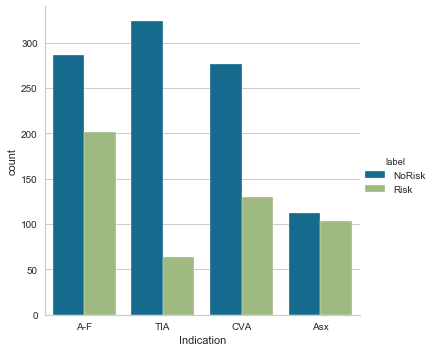

In [24]:
sns.set_style("whitegrid")
vis4 = sns.catplot(x="Indication", hue="label", data=clean_data, kind="count")

The initial reaction here, is that the majority of TIA labeled patients in our dataset are classified as a norisk patient. CVA also has a much higher norisk result than that of those laballed as to be at risk.

We can take a brief look at the mean scores for each indication alongside the amount of risk and norisk patients in each section.

In [25]:
# Mean scores for each Indication alongside each label
clean_data_dummy.groupby(["Indication", "Risk", "NoRisk"]).mean()

IPSI     Contra
Indication Risk NoRisk                      
A-F        0    1       76.452962  39.233449
           1    0       87.559406  81.267327
Asx        0    1       78.151786  35.705357
           1    0       82.788462  82.259615
CVA        0    1       74.877256  46.028881
           1    0       85.969231  88.038462
TIA        0    1       73.669753  46.595679
           1    0       85.375000  85.625000

This table of results shows that patients who have a risk classification, have much higher mean scores in terms of IPSI and Contra, whilst most of the norisk patients have a classification mean score which is relatively low in comparison.

### Pairplots & Correlation

The pairplot function of seaborn is useful to see multiple plots in a single result rather than needing to input multiple solo plots. The plots below show how the Contra and IPSI correlate with each other, whilst also showing what values of the dataset lead to the risk and norisk classification in the label column.

https://seaborn.pydata.org/generated/seaborn.pairplot.html

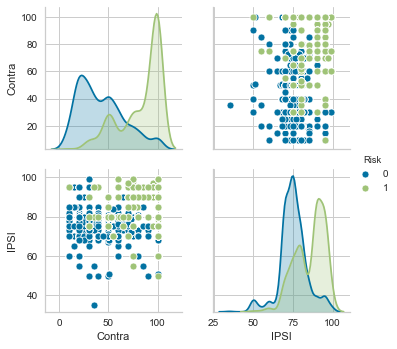

In [26]:
medical = clean_data_dummy
g = sns.pairplot(medical, hue="Risk", vars=["Contra", "IPSI"])

The values shown as green are the values that are of a risk label, whilst the blue show the values to which there is a norisk label. What's important here is that it appears that risk is associated with a high Contra score, whilst IPSI is not as important.

We can better visualise the correlation here by placing the values into a correlation matrix.

https://seaborn.pydata.org/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap

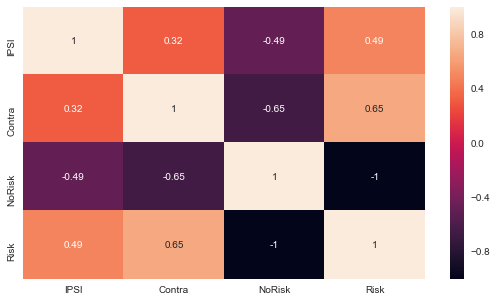

In [27]:
plt.figure(figsize=(9,5))
sns.heatmap(clean_data_dummy.corr(), annot=True)

As we saw from the plots above, the Contra has a 0.65 positive correlation with Risk, and a -0.65 negative correlation with NoRisk. This indicates that when the Contra score increases, the chance of Risk also increases.

IPSI sits at a 0.49 and -0.49 score respectively, which shows while it does have a positive/negative correlation with each result, it is not as impactful as Contra is.

The correlation relationship of Risk against NoRisk is an expected exact -1. This indicates there is a perfect downhill negative relationship for NoRisk against Risk. A 1 score just means there is an exact uphill positive relationship, but is expected as the value is being tested against itself, and this result is always expected to be 1.

### Distribution

Next, we can visualise the distribution of the values for IPSI and Contra across the whole dataset.

https://seaborn.pydata.org/generated/seaborn.distplot.html

We can see below, that the values of IPSI are right skewed, whilst the Contra values are more evenly distributed.

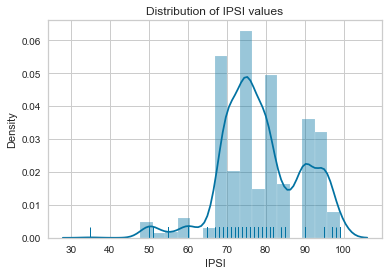

In [28]:
# Visualise the distribution across the IPSI value
sns.distplot(clean_data["IPSI"], bins = 20, rug=True)
plt.title("Distribution of IPSI values")
plt.ylabel("Density")
plt.show()

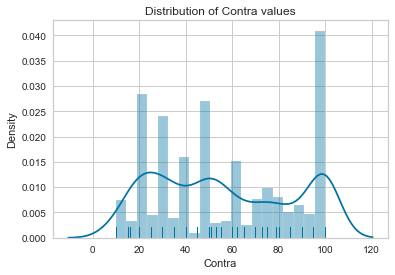

In [29]:
# Visualise the distribution across the Contra value
sns.distplot(clean_data["Contra"], bins = 20, rug=True)
plt.title("Distribution of Contra values")
plt.ylabel("Density")
plt.show()

The distribution graphs help to give a visual understanding of where most of the values lie in the dataset. The IPSI data tends to fall mostly in the 60-80 value area, as indicated by the distribution line, whilst the Contra tends to have a more equal variation of values that flow across the entire dataset, with the highest values seemingly appearing at a 100 value, the highest possible value.

### Boxplots

A boxplot is the next graph that we will use to visualise our data. A boxplot is useful to show the distribution of the quantitative data in a way that helps to facilitate comparisons, in this case the comparisons of the quantitative data towards risk and norisk.

The boxes indicate the interquartile range, and the line in the centre of each boxplot indicates where the median of the box lies. The whiskers are used to show the extent of the rest of the values, with the diamonds at either side showing the outliers of the dataset in this particular boxplot.

https://seaborn.pydata.org/generated/seaborn.boxplot.html

From the IPSI boxplot below, we can see that the majority of the IPSI values for norisk are below 80, with a few outliers nearer the bottom of the boxplot, and a single outlier located at the value of 99. Whilst the risk patients generally have a score above 80, with the median here of 89. A few outliers are present for the risk patients, who have a IPSI value between 50 and 60.

Text(0.5, 1.0, 'Boxplot of IPSI scores against Risk/NoRisk')

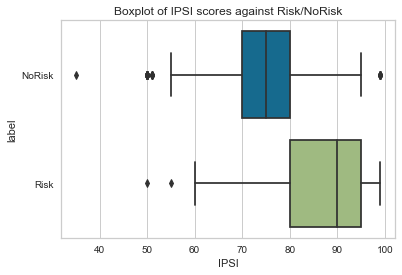

In [30]:
# Create a boxplot that uses IPSI as the quantitative measure, and the label as the comparison
sns.boxplot(x = clean_data["IPSI"], y = clean_data["label"])
plt.title("Boxplot of IPSI scores against Risk/NoRisk")

From the Contra boxplot, the picture is much clearer. The majority of norisk patients have a Contra value below 60 and no visible outliers. The risk patients are mostly above 75, with the median here of around 96, a very high value, with a few outliers below 40.

Text(0.5, 1.0, 'Boxplot of Contra scores against Risk/NoRisk')

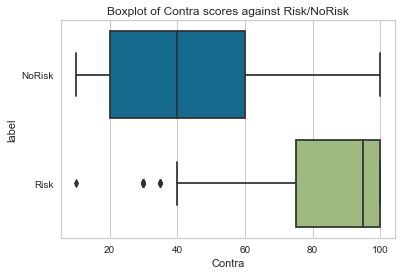

In [31]:
# Create a boxplot that uses Contra as the quantitative measure, and the label as the comparison
sns.boxplot(x = clean_data["Contra"], y = clean_data["label"])
plt.title("Boxplot of Contra scores against Risk/NoRisk")

This shows that the overall distribution of Contra values is of more importance than IPSI values, as the majority of risk patients maintain high Contra scores, with a lower distribution being below a value of 40.

While IPSI having a high value doesn't necessarily mean you are of risk, having a high Contra score means that the majority of the time, you will end up with a classification of risk.

The next thing to look at, is distribution of IPSI and Contra towards which indication they are assigned to.

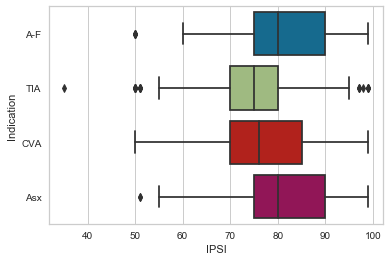

In [32]:
# Create a boxplot that uses IPSI as the quantitative measure, and the Indication as the comparison
sns.boxplot(x = clean_data["IPSI"], y = clean_data["Indication"])
plt.title("Boxplot of IPSI against each Indication")

As seen before, the IPSI values generally seem to more distributed between 70 and 100 across all 4 indication classes. We can see a few outliers between the different classes, but none that seem to be substantial here.

The boxplot against the Indication class sees no real difference here, as the values are mostly distributed in a way that doesn't give a clear insight as to whether the Indication class has an effect on the end classification.

The boxplot for the Contra however is a little bit more interesting.

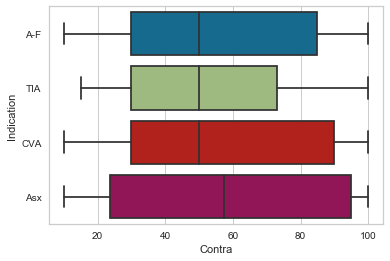

In [33]:
# Create a boxplot that uses Contra as the quantitative measure, and the Indication as the comparison
sns.boxplot(x = clean_data["Contra"], y = clean_data["Indication"])
plt.title("Boxplot of Contra against each Indication")

Whilst the boxplot for IPSI toward Indication class is mostly as expected, the Contra boxplot is more interesting. This is because the wide variety of Contra values range across all classes and shows no outliers at all. 

The most important thing to get from this boxplot, is the Asx class, and TIA class. The Asx class has a very high spread of data within its interquartile range, whilst TIA is more evenly spread across the middle of the dataset. We can also see that 3 of the 4 classes have an exact median score of around 50, whilst Asx has a slightly higher median of around 58.

In [34]:
# Consider cutting later

Q1 = clean_data.quantile(0.25)
Q3 = clean_data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

IPSI      12.0
Contra    55.0
NoRisk     1.0
Risk       1.0
dtype: float64


### Normalise the values

https://www.statisticshowto.datasciencecentral.com/normalized/

Normalisation is a key technique for the machine learning aspect of this analysis. It helps to change the values to a common scale, without distorting the differences in the ranges of values. It changes all values to instead have a value between 0 and 1, which is known as -feature scaling-

It is achieved by the following equation;

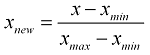

In [35]:
# Normalise the IPSI and Contra values so they can be easily evaluated within models
clean_data["IPSI"] = (clean_data["IPSI"] - clean_data["IPSI"].min()) \
/ (clean_data["IPSI"].max() - clean_data["IPSI"].min())

clean_data["Contra"] = (clean_data["Contra"] - clean_data["Contra"].min()) \
/ (clean_data["Contra"].max() - clean_data["Contra"].min())

clean_data.head()

,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label,NoRisk,Risk
0,A-F,no,no,yes,no,no,0.671875,0.111111,NoRisk,1,0
1,TIA,no,no,no,no,no,0.546875,0.555556,NoRisk,1,0
2,A-F,no,yes,yes,no,no,0.937500,0.333333,Risk,0,1
3,TIA,no,no,yes,no,no,0.859375,0.833333,Risk,0,1
4,CVA,no,no,no,no,no,0.546875,0.111111,NoRisk,1,0


## Preprocessing the data using One-Hot Encoding

Earlier in the code we ran One Hot Encoding for the Risk and NoRisk categories, but this time we are going to run the LabelEncoder feature of sklearn to change all our categorical yes and no values, indication values and the label variable to numbers.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

First we need to know what unique labels we have for each column of the dataset, so we will find those first.

In [36]:
print("Indication' : ",clean_data['Indication'].unique())
print("Diabetes' : ",clean_data['Diabetes'].unique())
print("IHD' : ",clean_data['IHD'].unique())
print("Hypertension' : ",clean_data['Hypertension'].unique())
print("Arrhythmia' : ",clean_data['Arrhythmia'].unique())
print("History' : ",clean_data['History'].unique())
print("label' : ",clean_data['label'].unique())

Indication' :  ['A-F' 'TIA' 'CVA' 'Asx']
Diabetes' :  ['no' 'yes']
IHD' :  ['no' 'yes']
Hypertension' :  ['yes' 'no']
Arrhythmia' :  ['no' 'yes']
History' :  ['no' 'yes']
label' :  ['NoRisk' 'Risk']


Now that we know these values, we can create a new dataframe that will only include the dummy versions of these, through the use of the LabelEncoder sklearn preprocessing method.

In [37]:
# create the variable that the new data will go into, thus maintaining data integrity
clean_data_process = clean_data
# create the Labelencoder object
le = preprocessing.LabelEncoder()
# convert the categorical columns into numeric
clean_data_process['Indication'] = le.fit_transform(clean_data['Indication'])
clean_data_process['Diabetes'] = le.fit_transform(clean_data['Diabetes'])
clean_data_process['IHD'] = le.fit_transform(clean_data['IHD'])
clean_data_process['Hypertension'] = le.fit_transform(clean_data['Hypertension'])
clean_data_process['Arrhythmia'] = le.fit_transform(clean_data['Arrhythmia'])
clean_data_process['History'] = le.fit_transform(clean_data['History'])
clean_data_process['label'] = le.fit_transform(clean_data['label'])
 
# display the initial records
clean_data_process.head()

,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label,NoRisk,Risk
0,0,0,0,1,0,0,0.671875,0.111111,0,1,0
1,3,0,0,0,0,0,0.546875,0.555556,0,1,0
2,0,0,1,1,0,0,0.937500,0.333333,1,0,1
3,3,0,0,1,0,0,0.859375,0.833333,1,0,1
4,2,0,0,0,0,0,0.546875,0.111111,0,1,0


Now this is done, we need to remove the label, norisk and risk columns from the dataset, as we don't want the model to know these 'answers' unless we want it to. If these are not removed, then the model training will be for nothing as the model will always know the answers already.

How does one learn if one already knows the answer to the question.

It is important to remember for later, that in the tests a result of 0 indicates NoRisk, and 1 indicates Risk, we can see this above so we know it to be true for later.

In [38]:
# removing the label, risk and no risk columns
riskclassify = [col for col in clean_data_process.columns if col not in ['Risk','NoRisk','label']]
meddata = clean_data_process[riskclassify]
meddata.head()

,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra
0,0,0,0,1,0,0,0.671875,0.111111
1,3,0,0,0,0,0,0.546875,0.555556
2,0,0,1,1,0,0,0.937500,0.333333
3,3,0,0,1,0,0,0.859375,0.833333
4,2,0,0,0,0,0,0.546875,0.111111


Now we have our new dataframe minus our classification target, it's time to begin some model training.

### Model Training

The goal of our model training is classification of risk vs norisk. We have our data split now, all we need to do now is decide what models are worthwhile to test on.

A classification model tries to draw some conclusion from the input values given for training. It will predict the class labels/categories for the new data, in our case, whether that patient will be at risk or not.

The aim of the model is to achieve a low False Negative, this means that the aim is to make sure that our lowest prediction metric is classifying a patient with NoRisk when they are actually at Risk.

The first thing to do, is declare our target. This is going to be the label column of our clean_data_process dataset. Since we made changes to the original dataset, we will use the label column from the dataset we split the label from above.

In [39]:
#declare the target of the model
target = clean_data_process['label']

Now we want to declare our x and y variables. After this is done, we will split the data up into a 70/30 training and testing split. And then check the shapes so we can see that this was done correctly. 

The reason why our y_train and y_test are not a 2d array, is because they contain only our target, and have no other feature columns present, whilst our x_train and x_test have all our categorical features within.

In [40]:
#create and split up the training and test data for the models
#random state is used so that we get reproducible results every time.
x = meddata
y = target

#create the train and test sets
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.30, shuffle=False)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1050, 8)
(1050,)
(450, 8)
(450,)


#### Define our Null Accuracy

In [41]:
# examine class distribution
print(y_test.value_counts(), "\n")

# calculate the percentage of 0
print(1 - y_test.mean(), "\n")

# calculate the null accuracy, in a single line of code
print("%0.2f " % max(y_test.mean(), 1 - y_test.mean()))

0    300
1    150
Name: label, dtype: int64 

0.6666666666666667 

0.67 


So our model needs to always achieve more than the above score, otherwise it would be classified as a dumb model

### Naive Bayes Gaussian Model

The first classification model we will do is the Naive Bayes model. This is a good choice due to this algorithms ability to classify an outcome given a certain set of events. The dataset we have has events that lead to the risk or no risk result.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

In [42]:
#create an object of the type GaussianNB
gnb = GaussianNB()
#train the algorithm on training data and predict using the testing data
pred = gnb.fit(x_train, y_train).predict(x_test)
#print(pred.tolist())

#print the accuracy score of the model
nbaccuracy = accuracy_score(y_test, pred, normalize = True)
print("Naive-Bayes classification accuracy score : %0.2f " % nbaccuracy)

Naive-Bayes classification accuracy score : 0.90 


Accuracy score is printed above. Lets look at some metrics for this, namely the classification report.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

The classification report feature of sklearn is useful, as it shows us our score for each classification target, in this case no risk as 0, and risk as 1. It shows this as the measure of precision, recall, f1 score and support.

Precision - What percent of our predictions were correct?

Recall - What percent of the positive cases did we catch?

F1 score – What percent of positive predictions were correct?

Support - How many values did we have in each classification category (no risk vs risk)

This is then placed inside a confusion matrix, so we can see our scores for TP, FP, FN and TN.
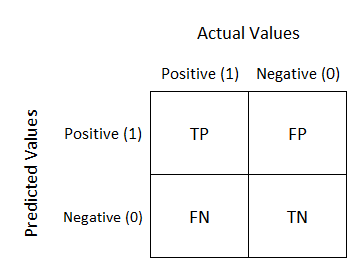

In [43]:
print(metrics.classification_report(y_test, pred))
cf_nb = confusion_matrix(y_test, pred)
print(cf_nb)

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       300
           1       0.96      0.71      0.82       150

    accuracy                           0.90       450
   macro avg       0.92      0.85      0.87       450
weighted avg       0.90      0.90      0.89       450

[[296   4]
 [ 43 107]]


In [44]:
nbsqr = metrics.mean_squared_error(y_test, pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

Mean Absolute Error: 0.10444444444444445
Mean Squared Error: 0.10444444444444445
Root Mean Squared Error: 0.3231786571610886


The results look good, but they are not very visually friendly. We can create better visuals of these by placing the classification report into a visual format using the function classification_report from yellowbrick.

https://www.scikit-yb.org/en/latest/api/classifier/classification_report.html

To plot the confusion matrix we can define our own function to create visual representations of these. The code is obtained from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [45]:
classes = ['NoRisk', 'Risk']
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    sns.set_style("dark")
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cf_nb = confusion_matrix(y_test, pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cf_nb = cf_nb.astype('float') / cf_nb.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cf_nb)

    fig, ax = plt.subplots()
    im = ax.imshow(cf_nb, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cf_nb.shape[1]),
           yticks=np.arange(cf_nb.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cf_nb.max() / 2.
    for i in range(cf_nb.shape[0]):
        for j in range(cf_nb.shape[1]):
            ax.text(j, i, format(cf_nb[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cf_nb[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

First lets visualise the classification report.

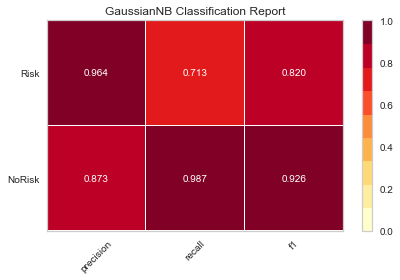

In [46]:
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(gnb, classes=['NoRisk','Risk'])
visualizer.fit(x_train, y_train) # Fit the training data to the visualizer
visualizer.score(x_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

The label helps to understand this report much better than the simple version we had above. Next create two confusion matrices, one will be unnormalised, and look like the one above, whilst the other will be normalised to show a percentile value within the matrix.

Confusion matrix, without normalization
[[296   4]
 [ 43 107]]


Normalized confusion matrix
[[0.99 0.01]
 [0.29 0.71]]


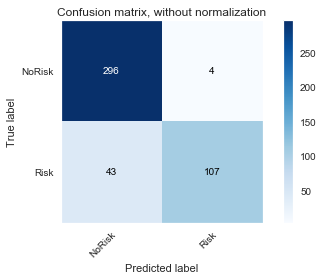

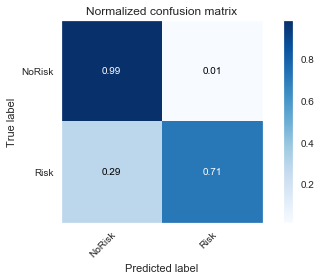

In [47]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes,
                      title='Confusion matrix, without normalization')
print("\n")
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

This is much more useful in percentile form, now we can see the values of our matrix, and also how that equates in a percentile form for a more accurate error matrix.

How will the outcome of this model change if we do this with cross validation instead of splitting the train and test sets ourselves?

In [48]:
#create an object of the type GaussianNB
gnb = GaussianNB()
#Train the algorithm
gauss_score = cross_val_score(gnb, x, y, cv= 10, scoring='accuracy')
print(gauss_score)
print("\n")
print("Naive Bayes Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (gauss_score.mean(), gauss_score.std() * 2))

[0.89 0.93 0.88 0.92 0.93 0.89 0.85 0.87 0.91 0.91]


Naive Bayes Cross-Validation Accuracy : 0.90 (+/- 0.05)


The mean accuracy here is shown above, which looks to be in line with what we get when we run it on our train/test split, which is good. Looking at the 10 scores we get, most sit around where we expect, with only 2 dipping to 0.85 and 0.87 respectively. 

The variance of our accuracy scores is 0.05. Below are the same classification report and confusion matrix we made before, but instead for cross validation. 

As cross_val_score cannot be used to create prediction reports such as the classification report, we need to use cross_val_predict instead here.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html

In [49]:
#create a confusion matrix for the dataset through cross validation folds
y_pred = cross_val_predict(gnb, x, y, cv=10)
print(metrics.classification_report(y, y_pred))
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1000
           1       0.95      0.73      0.83       500

    accuracy                           0.90      1500
   macro avg       0.92      0.86      0.88      1500
weighted avg       0.90      0.90      0.89      1500

[[981  19]
 [134 366]]


In [50]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, y_pred)))

Mean Absolute Error: 0.102
Mean Squared Error: 0.102
Root Mean Squared Error: 0.31937438845342625


### Linear SVC Model

Creating the Linear Support Vector Classification model.

SVM Classifiers offer good accuracy and perform faster prediction compared to Naïve Bayes algorithm. They also use less memory because they use a subset of training points in the decision phase. SVM works well with a clear margin of separation and with high dimensional space.

Lets begin creating the model.

In [51]:
svc_model = LinearSVC()
#train the algorithm on training data and predict using the testing data
pred = svc_model.fit(x_train, y_train).predict(x_test)
#print the accuracy score of the model
svcaccuracy = accuracy_score(y_test, pred, normalize = True)
print("LinearSVC classification accuracy score : %0.2f " % svcaccuracy)

LinearSVC classification accuracy score : 0.96 


The accuracy is very good, above 95%! Lets create the classification report and confusion matrix for this model, as well as calculate the mean error metrics.

In [52]:
print(metrics.classification_report(y_test, pred))
cf_svc = confusion_matrix(y_test, pred)
print(cf_svc)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       300
           1       0.95      0.94      0.94       150

    accuracy                           0.96       450
   macro avg       0.96      0.96      0.96       450
weighted avg       0.96      0.96      0.96       450

[[292   8]
 [  9 141]]


In [53]:
linearsqr = metrics.mean_squared_error(y_test, pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

Mean Absolute Error: 0.03777777777777778
Mean Squared Error: 0.03777777777777778
Root Mean Squared Error: 0.19436506316151


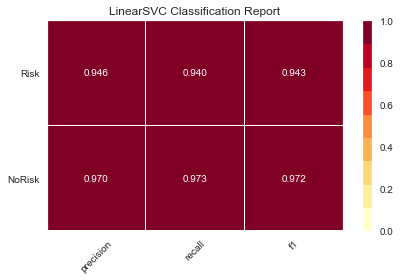

In [54]:
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(svc_model, classes=['NoRisk','Risk'])
visualizer.fit(x_train, y_train) # Fit the training data to the visualizer
visualizer.score(x_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

As before, we have our classification report and confusion matrix (see below for visual representation). We can see a very high achieved accuracy in all areas in the report, not unexpected if you consider we achieve an accuracy of 96%. What is important to notice is that we are not lacking in any area, and all results are very equal in terms of percentile accuracy.

We have 97% precision accuracy of NoRisk classification and 94% accuracy of Risk classification.

Confusion matrix, without normalization
[[292   8]
 [  9 141]]


Normalized confusion matrix
[[0.97 0.03]
 [0.06 0.94]]


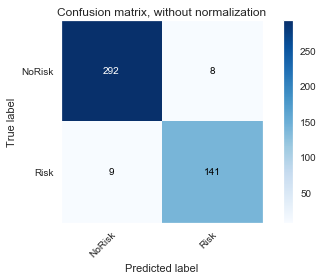

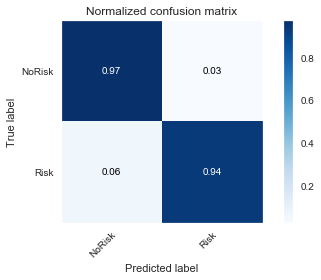

In [55]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes,
                      title='Confusion matrix, without normalization')
print("\n")
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

Again, lets run cross validation against this to make sure we are not overfitting and getting an accuracy higher than we should be.

In [56]:
svc_model = LinearSVC()
#Train the algorithm
svcscore = cross_val_score(svc_model, x, y, cv = 10, scoring='accuracy')
print(svcscore)
print("\n")
print("Linear SVC Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (svcscore.mean(), svcscore.std() * 2))

[0.97 0.97 0.97 0.96 0.99 0.98 0.95 0.95 0.99 0.95]


Linear SVC Cross-Validation Accuracy : 0.97 (+/- 0.03)


The 10 scores look good, we are hitting good accuracy, similar to what we get with the train/test split, in most cases actually achieving higher than we did overall with our train/test split.

This is visualised below for easier readability.

In [57]:
y_pred = cross_val_predict(svc_model, x, y, cv = 10)
print(metrics.classification_report(y, y_pred))
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1000
           1       0.96      0.94      0.95       500

    accuracy                           0.97      1500
   macro avg       0.97      0.96      0.96      1500
weighted avg       0.97      0.97      0.97      1500

[[981  19]
 [ 31 469]]


In [58]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, y_pred)))

Mean Absolute Error: 0.03333333333333333
Mean Squared Error: 0.03333333333333333
Root Mean Squared Error: 0.18257418583505536


### K-Nearest Neighbours Model

KNN or K-Nearest-Neighbours is a simple and easy to implement algorithm. This algorithm assumes that similar things exist in close proximity, which we define as K.

We can achieve varying results of accuracy by doing something as simple as changing the sum of K for the model. As we have a test set of 450, 5 seems like a good number to start on, it will give a good degree of space around which the model can make suitable predictions.

It is important to note that your K value shouldn't ever really be an even number, this is because an even number can have ties in its results, but this can be avoided by simply choosing an odd number for K.

In [59]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(x_train, y_train)
# predict the response
pred = neigh.predict(x_test)
# evaluate accuracy
knnaccuracy = accuracy_score(y_test, pred, normalize = True)
print ("KNeighbors classification accuracy score : %0.2f " % knnaccuracy)

KNeighbors classification accuracy score : 0.96 


In the case of K = 5, the model achieves a good accuracy. Lets create our classification report and confusion matrix, to get a better visual idea of how the results are spread out.

In [60]:
print(metrics.classification_report(y_test, pred))
cf_knn = confusion_matrix(y_test, pred)
print(cf_knn)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       300
           1       0.94      0.93      0.94       150

    accuracy                           0.96       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.96      0.96      0.96       450

[[291   9]
 [ 10 140]]


In [61]:
knnsqr = metrics.mean_squared_error(y_test, pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

Mean Absolute Error: 0.042222222222222223
Mean Squared Error: 0.042222222222222223
Root Mean Squared Error: 0.20548046676563256


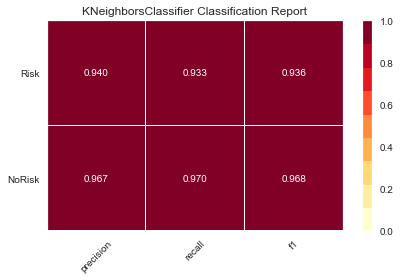

In [62]:
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(neigh, classes=['NoRisk','Risk'])
visualizer.fit(x_train, y_train) # Fit the training data to the visualizer
visualizer.score(x_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

The percentile results in this classification report look very similar to what was achieved with LinearSVC. What is very interesting is, although we did achieve a more or less similar accuracy result, if we look at the matrix, we have

291-9 and 10-140, in our LinearSVC these numbers were 292-8 and 9-141. 

This shows that the models achieve a similar accuracy, but the LinearSVC gets 2 more classifications correct.

Confusion matrix, without normalization
[[291   9]
 [ 10 140]]


Normalized confusion matrix
[[0.97 0.03]
 [0.07 0.93]]


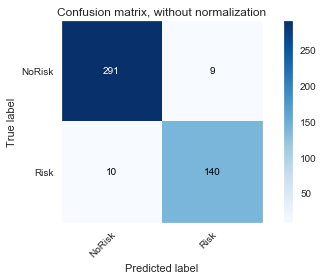

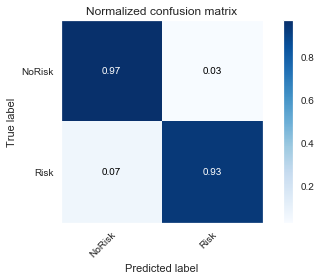

In [63]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes,
                      title='Confusion matrix, without normalization')
print("\n")
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

Our normalised confusion matrix shows a 97% precision for NoRisk classification and a 93% precision for Risk classification.

Lets run cross validation on KNN and see how it differs again from the train/test split we did before.

In [64]:
neigh = KNeighborsClassifier(n_neighbors=5)
#Train the algorithm
knnscore = cross_val_score(neigh, x, y, cv=10, scoring='accuracy')
print(knnscore)
print("\n")
print("KNeighbours Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (knnscore.mean(), knnscore.std() * 2))

[0.99 0.97 0.97 0.99 0.98 0.97 0.94 0.97 0.97 0.94]


KNeighbours Cross-Validation Accuracy : 0.97 (+/- 0.03)


CV achieves a mean accuracy of 97% with a variance of 0.03. The scores themselves stay near 98% except for a couple of scores at 94%, which decreases the mean to 97.

In [65]:
y_pred = cross_val_predict(neigh, x, y, cv = 10)
print(metrics.classification_report(y, y_pred))
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1000
           1       0.96      0.95      0.95       500

    accuracy                           0.97      1500
   macro avg       0.97      0.96      0.96      1500
weighted avg       0.97      0.97      0.97      1500

[[978  22]
 [ 25 475]]


### Finding the best value for K for the KNN model

The K value can have an impact on what sort of accuracy the model achieves, due to the way KNN works. Due to this, lets run a comparison and visualise it within a graph, to see how increasing the K value changes the accuracy.

In [66]:
#search for an optimal value for K for KNN
k_range = range(1, 31)
k_scores = []
for k in k_range:
    neigh = KNeighborsClassifier(n_neighbors=k)
    knnscore = cross_val_score(neigh, x, y, cv=10, scoring='accuracy')
    k_scores.append(knnscore.mean())
print(k_scores)

[0.9879999999999999, 0.9833333333333332, 0.9786666666666666, 0.9733333333333334, 0.9686666666666666, 0.97, 0.9639999999999999, 0.9606666666666668, 0.9593333333333334, 0.9533333333333331, 0.952, 0.9453333333333334, 0.9486666666666667, 0.9473333333333332, 0.95, 0.95, 0.9493333333333334, 0.9506666666666665, 0.9466666666666667, 0.9466666666666667, 0.9473333333333335, 0.9433333333333331, 0.9426666666666668, 0.9380000000000001, 0.9380000000000001, 0.9339999999999999, 0.9339999999999999, 0.9246666666666667, 0.9226666666666669, 0.9200000000000002]


We have the scores, now lets plot the graph. We will use the range of K as our x value, and the accuracy scores as the y value.

Text(0, 0.5, 'Cross-Validated Accuracy')

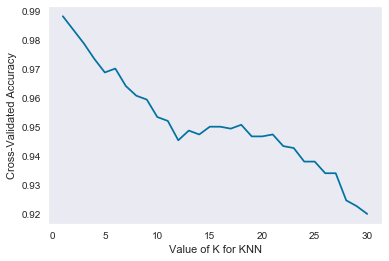

In [67]:
plt.plot(k_range,k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

The graph shows that for this dataset we have, as the K value is increased, we see a decrease in accuracy measurement, dropping to as low as 92% when K is at the maximum tested value of 31.

What's interesting is that while 92% is the lowest accuracy we get for K = 31, this accuracy is still higher than that which the Naive Bayes model managed to achieve.

We found that the optimal K value appears to be 1, but that is not a good choice. If K = 1, we will have a higher bias, although we know that a K = 1 value is a 99% accuracy with cross validation. 

When we increase K, the training error will increase (increase bias), but the test error may decrease at the same time (decrease variance). We can think that when K becomes larger, since it has to consider more neighbors, its model is more complex.

For the reason of keeping the K value as an odd number and avoiding 1, lets go with 3 as our new K value and run cross validation again.

In [68]:
neigh = KNeighborsClassifier(n_neighbors=3)
#Train the algorithm
knnscore = cross_val_score(neigh, x, y, cv=10, scoring='accuracy')
print(knnscore)
print("\n")
print("KNeighbours Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (knnscore.mean(), knnscore.std() * 2))

[1.   0.98 0.97 0.99 0.98 0.99 0.96 0.99 0.97 0.95]


KNeighbours Cross-Validation Accuracy : 0.98 (+/- 0.03)


Looking at the scores for the 10 cross validation folds, there is a noticeable 100% accuracy in the first run. The results stay around 98% for the rest of the tests, concluding with a mean accuracy score of 98%, with a variance of 0.03.

We can compute the results into a classification report and confusion matrix to see our scores in more depth.

In [69]:
y_pred = cross_val_predict(neigh, x, y, cv = 10)
print(metrics.classification_report(y, y_pred))
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1000
           1       0.97      0.97      0.97       500

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500

[[985  15]
 [ 17 483]]


In [70]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, y_pred)))

Mean Absolute Error: 0.021333333333333333
Mean Squared Error: 0.021333333333333333
Root Mean Squared Error: 0.1460593486680443


### Logistic Regression

Logistic Regression is an algorithm similar to Linear Regression used before, but it does a better job at making a prediction based on a binary output, in our case 0 and 1, which are associated with our norisk and risk target.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

We set our solver to lbfgs, which means it will handle multinomial loss. The result will be more than likely the same for this dataset if we instead used liblinear, but in this case we are going to try out lbfgs. The max iter is set to 1000, the default for this is 100, but to make sure we don't run into any convergence errors, we are gonna increase this.

In [71]:
logreg =LogisticRegression(solver='lbfgs', max_iter=1000, multi_class="auto")
logreg.fit(x_train, y_train)
# predict the response
pred = logreg.predict(x_test)
# evaluate accuracy
logregaccuracy = accuracy_score(y_test, pred, normalize = True)
print ("Logistic Regression classification accuracy score : %0.2f " % logregaccuracy)

Logistic Regression classification accuracy score : 0.95 


Our accuracy is 95%, not bad at all. We can see more stats below in our classification report and confusion matrix.

In [72]:
print(metrics.classification_report(y_test, pred))
cf_lr = confusion_matrix(y_test, pred)
print(cf_lr)
print("\n")
logregsqr = metrics.mean_squared_error(y_test, pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       300
           1       0.94      0.90      0.92       150

    accuracy                           0.95       450
   macro avg       0.95      0.94      0.94       450
weighted avg       0.95      0.95      0.95       450

[[292   8]
 [ 15 135]]


Mean Absolute Error: 0.051111111111111114
Mean Squared Error: 0.051111111111111114
Root Mean Squared Error: 0.22607766610417562


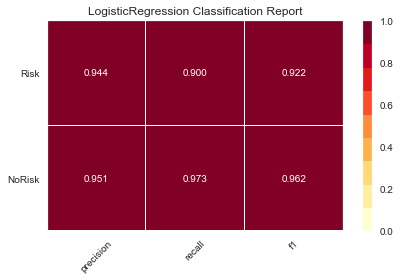

In [73]:
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(logreg, classes=['NoRisk','Risk'])
visualizer.fit(x_train, y_train) # Fit the training data to the visualizer
visualizer.score(x_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

We see similar results to some of the previous models, where the lower percentile scores tend to be towards classification of the Risk. 

Confusion matrix, without normalization
[[292   8]
 [ 15 135]]


Normalized confusion matrix
[[0.97 0.03]
 [0.1  0.9 ]]


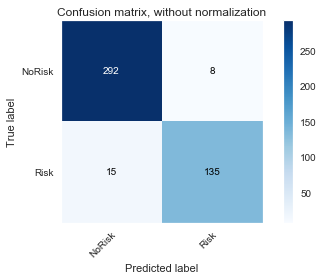

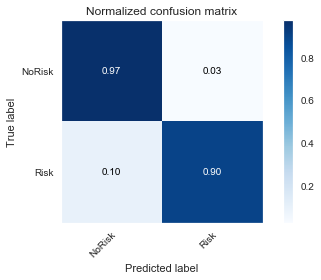

In [74]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes,
                      title='Confusion matrix, without normalization')
print("\n")
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

For our TP and TN, we maintain good percentile scores of 97% and 90% respectively. Although it would be better if the 90% was higher, it can't be helped too much for this model. 

Lets take a look again at cross validation for this model solution, to see if anything changes.

In [75]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logregscore = cross_val_score(logreg, x, y, cv=10, scoring='accuracy')
print(logregscore)
print("\n")
print("Logistic Regression Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (logregscore.mean(), logregscore.std() * 2))

[0.96 0.97 0.99 0.95 0.97 0.95 0.94 0.94 0.97 0.95]


Logistic Regression Cross-Validation Accuracy : 0.96 (+/- 0.03)


There is a small accuracy increase here, with good high accuracy scores within the 10 runs. Our mean score is 96% with the variance coming up as 0.03, similar to the variance found within previous models too.

Classification report and confusion matrix for cross validation are also shown.

In [76]:
y_pred = cross_val_predict(logreg, x, y, cv = 10)
print(metrics.classification_report(y, y_pred))
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)
print("\n")
print('Mean Absolute Error:', metrics.mean_absolute_error(y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, y_pred)))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1000
           1       0.97      0.91      0.94       500

    accuracy                           0.96      1500
   macro avg       0.96      0.95      0.95      1500
weighted avg       0.96      0.96      0.96      1500

[[985  15]
 [ 47 453]]


Mean Absolute Error: 0.04133333333333333
Mean Squared Error: 0.04133333333333333
Root Mean Squared Error: 0.2033060090930254


### Decision Tree

We have ran many other models, but one of the most important is the Decision Tree. The best reason to use a decision tree, is to get a visual view as to how the algorithm splits the training data and comes to the decision that we see at the end when it begins to predict results.

Lets fit the data to the model, and get our accuracy score.

In [77]:
#Create the decision tree classifier
clf = tree.DecisionTreeClassifier(max_depth=5)
#adjusting max depth increases accuracy, all the way up to depth of 10 = 99% accuracy
#but this is hard to visually understand

#Train the classifier
clf = clf.fit(x_train, y_train)

#Predict what the response will be for the test dataset
pred = clf.predict(x_test)

#Model Accuracy
treeaccuracy = accuracy_score(y_test, pred, normalize = True)
print ("Decision Tree classification accuracy score : %0.2f " % treeaccuracy)

Decision Tree classification accuracy score : 0.96 


Accuracy is good, at 96%. Increasing the max depth will of course increase the accuracy, but can introduce overfitting of the model.

Important note about max depth - The max depth, defines how far in the depth the decision tree will go, from top to bottom. As expected a higher depth will allow a higher prediction accuracy, but also results in a higher chance of overfitting skewing the result of the model.

#### Visualising the Decision Tree

To visualise the decision tree, we will use the export feature of sklearn.tree called export_graphviz, which allows us to visualise our graph, and then save that as a file if we want it later on outside of the notebook.

https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

We define the feature names we want to show, and make sure to attach out training model to this. This will give us a graphical overview of the decision tree and how it comes to its decisions. The default separator for impurity score is Gini, which is not changed for the below visualisation. This can be changed to Entropy, if desired.

The Gini score is a metric that quantifies the purity of the node/leaf.
A Gini score greater than zero implies that samples contained within that node belong to different classes. 

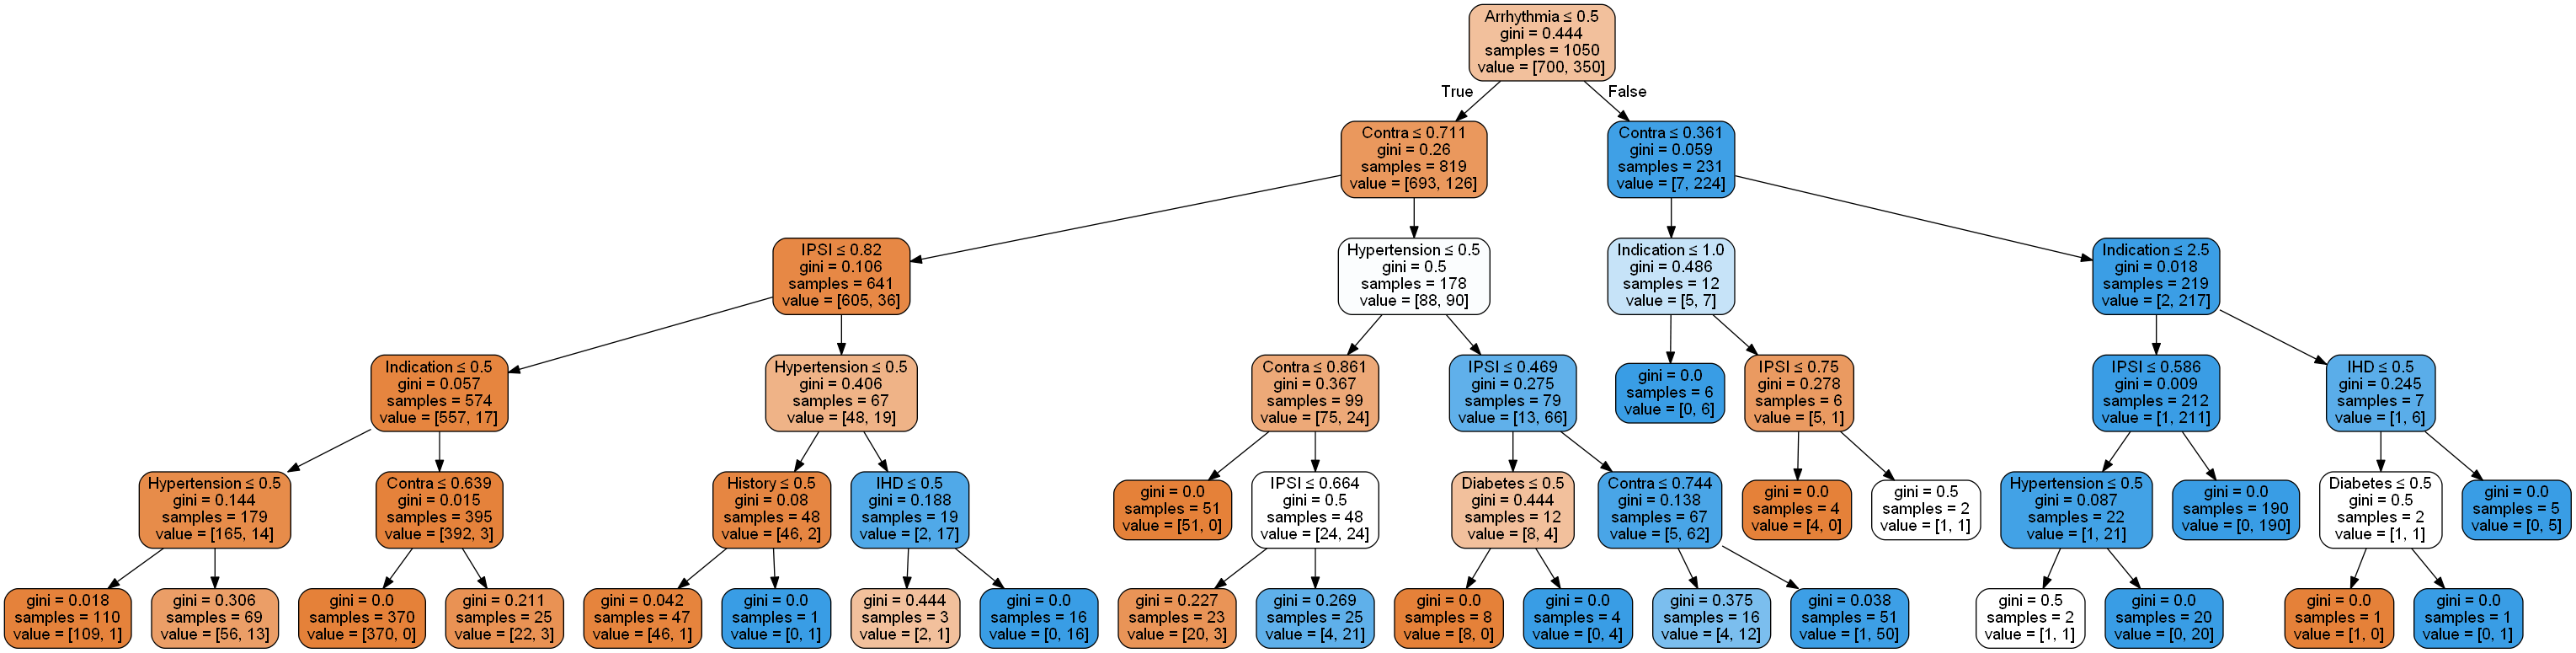

In [78]:
features = list(x.columns)

tree.export_graphviz(clf, out_file='tree.dot',
               filled=True, 
                     rounded=True,
                     special_characters=True, 
                     feature_names = features)

graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

From this decision tree, we can see how the model traisn itself on the data and target we give it. It is interesting to see how it begins initial split at the top of the tree. It uses Arrhythmia to split at the first step, then uses Contra, and so on.

In [79]:
print(metrics.classification_report(y_test, pred))
cf_dt = confusion_matrix(y_test, pred)
print(cf_dt)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       300
           1       0.96      0.91      0.94       150

    accuracy                           0.96       450
   macro avg       0.96      0.95      0.95       450
weighted avg       0.96      0.96      0.96       450

[[295   5]
 [ 13 137]]


In [80]:
dtsqr = metrics.mean_squared_error(y_test, pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

Mean Absolute Error: 0.04
Mean Squared Error: 0.04
Root Mean Squared Error: 0.2


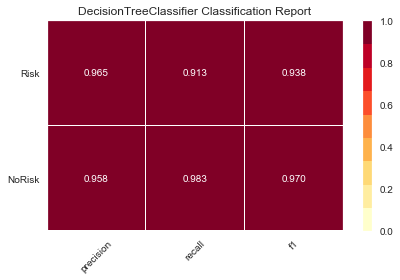

In [81]:
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(clf, classes=['NoRisk','Risk'])
visualizer.fit(x_train, y_train) # Fit the training data to the visualizer
visualizer.score(x_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

The lowest accuracy score in our report here is the Risk recall of 93%. What this means is that the decision tree had the most trouble classifying a Risk based on the data it was trained on, but overall the scores are still good, but this allows us to see where improvement could be made.

Confusion matrix, without normalization
[[295   5]
 [ 13 137]]


Normalized confusion matrix
[[0.98 0.02]
 [0.09 0.91]]


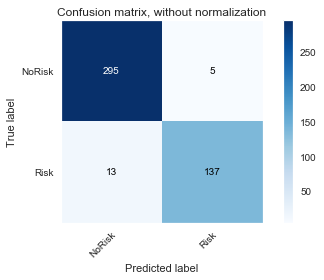

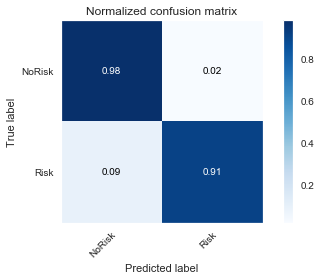

In [82]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes,
                      title='Confusion matrix, without normalization')
print("\n")
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

The Decision Tree model does a good job of making the predictions however, where we have only 2% FP and 7% FN.

It is not possible to visualise the Decision Tree for cross validation without fitting to the tree, so we will just look at the accuracy result instead since we already managed to visualise our Tree beforehand.

In [83]:
clf = tree.DecisionTreeClassifier(max_depth=5)
dtscore = cross_val_score(clf, x, y, cv=10, scoring='accuracy')
print(dtscore)
print("\n")
print("Decision Tree Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (dtscore.mean(), dtscore.std() * 2))

[0.97 0.95 0.98 0.95 0.97 0.98 0.95 0.97 0.98 0.95]


Decision Tree Cross-Validation Accuracy : 0.97 (+/- 0.03)


We run the cross validation using the same depth as before of 5, and as can be seen above, we achieve a slightly higher accuracy, 1% higher, with a pretty standard varaince of 0.03.

In [84]:
y_pred = cross_val_predict(clf, x, y, cv = 10)
print(metrics.classification_report(y, y_pred))
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1000
           1       0.96      0.93      0.95       500

    accuracy                           0.97      1500
   macro avg       0.97      0.96      0.96      1500
weighted avg       0.97      0.97      0.97      1500

[[982  18]
 [ 33 467]]


In [85]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, y_pred)))

Mean Absolute Error: 0.034
Mean Squared Error: 0.034
Root Mean Squared Error: 0.18439088914585774


If we want to visualise the predictions of the Decision Tree in a format such as that of a prediction to actual dataframe, we can use the DecisionTreeRegressor function of sklearn for this.

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [86]:
regressor = DecisionTreeRegressor()
regressor.fit(x_train, y_train)

y_pred = regressor.predict(x_test)

df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df.head(10)

,Actual,Predicted
1069,0,0.0
1070,1,1.0
1071,0,0.0
1072,1,1.0
1073,0,0.0
1074,1,1.0
1075,0,0.0
1076,0,0.0
1077,0,0.0
1078,0,0.0


### Neural Network 

The last model that will be used, is a Neural Network. 

A Neural Network, is essentially a series of algorithms that endeavors to recognise underlying relationships in a set of data through a process that mimics the way the human brain operates.
It is a very popular technique in the field of Deep Learning.

In [87]:
mlp = MLPClassifier(solver='sgd', max_iter=50000, hidden_layer_sizes=(20),\
                    batch_size=10, random_state=1, verbose=0)
mlp.fit(x_train, y_train)

pred = mlp.predict(x_test)
nnaccuracy = accuracy_score(y_test,pred, normalize=True)
print ("Neural Network classification accuracy score : %0.2f " % nnaccuracy)

Neural Network classification accuracy score : 0.96 


In [88]:
print(metrics.classification_report(y_test, pred))
cf_nn = confusion_matrix(y_test,pred)
print(cf_nn)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       300
           1       0.95      0.95      0.95       150

    accuracy                           0.96       450
   macro avg       0.96      0.96      0.96       450
weighted avg       0.96      0.96      0.96       450

[[292   8]
 [  8 142]]


In [89]:
nnsqr = metrics.mean_squared_error(y_test, pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

Mean Absolute Error: 0.035555555555555556
Mean Squared Error: 0.035555555555555556
Root Mean Squared Error: 0.18856180831641267


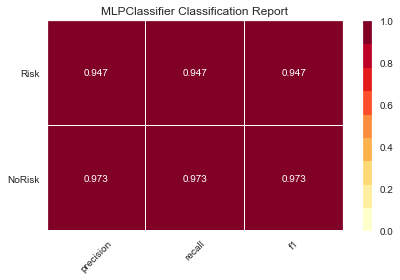

In [90]:
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(mlp, classes=['NoRisk','Risk'])
visualizer.fit(x_train, y_train) # Fit the training data to the visualizer
visualizer.score(x_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

Confusion matrix, without normalization
[[292   8]
 [  8 142]]


Normalized confusion matrix
[[0.97 0.03]
 [0.05 0.95]]


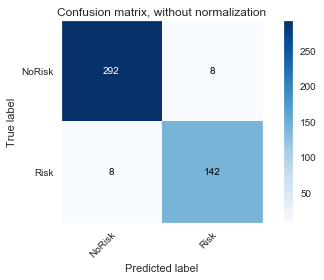

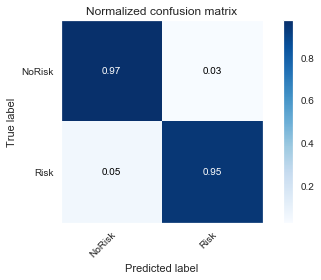

In [91]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes,
                      title='Confusion matrix, without normalization')
print("\n")
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

Neural Net Cross Validation

In [92]:
mlp = MLPClassifier(solver='sgd', max_iter=50000, hidden_layer_sizes=(20),\
                    batch_size=10, random_state=1, verbose=0)
#Train the algorithm
nnscore = cross_val_score(mlp, x, y, cv=10, scoring='accuracy')
print(nnscore)
print("\n")
print("Neural Net Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (nnscore.mean(), nnscore.std() * 2))

[0.97 0.97 0.99 0.97 0.98 0.97 0.95 0.95 0.99 0.97]


Neural Net Cross-Validation Accuracy : 0.97 (+/- 0.03)


In [93]:
y_pred = cross_val_predict(mlp, x, y, cv = 10)
print(metrics.classification_report(y, y_pred))
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1000
           1       0.97      0.94      0.95       500

    accuracy                           0.97      1500
   macro avg       0.97      0.96      0.97      1500
weighted avg       0.97      0.97      0.97      1500

[[986  14]
 [ 32 468]]


In [94]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, y_pred)))

Mean Absolute Error: 0.030666666666666665
Mean Squared Error: 0.030666666666666665
Root Mean Squared Error: 0.17511900715418263


### Evaluation

#### Accuracy Scores

In [95]:
print("Naive Bayes Accuracy Score : %0.2f" % nbaccuracy,"%")
print("Linear SVC Accuracy Score : %0.2f" % svcaccuracy,"%")
print("KNeighbours K=3 Accuracy Score : %0.2f" % knnaccuracy,"%")
print("Logistic Regression Accuracy Score : %0.2f" % logregaccuracy,"%")
print("Decision Tree Accuracy Score : %0.2f" % treeaccuracy,"%")
print("Neural Network Accuracy Score : %0.2f" % nnaccuracy,"%")

Naive Bayes Accuracy Score : 0.90 %
Linear SVC Accuracy Score : 0.96 %
KNeighbours K=3 Accuracy Score : 0.96 %
Logistic Regression Accuracy Score : 0.95 %
Decision Tree Accuracy Score : 0.96 %
Neural Network Accuracy Score : 0.96 %


Against the train/test data, the majority of models tested achieve 96% accuracy rounded.
It is important to keep in mind that our linear regression model did not use our train/test split, so for that reason it is not included in the evaluation. When it comes to cross-validation accuracy , each score except from Naive Bayes, achieved a mean accuracy 1% higher than what the train/test split was, with only KNN K=3 being the exception.

#### Cross Validation Accuracy scores

In [96]:
print("Naive Bayes Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (gauss_score.mean(), gauss_score.std() * 2))
print("Linear SVC Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (svcscore.mean(), svcscore.std() * 2))
print("KNeighbours K=3 Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (knnscore.mean(), knnscore.std() * 2))
print("Logistic Regression Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (logregscore.mean(), logregscore.std() * 2))
print("Decision Tree Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (dtscore.mean(), dtscore.std() * 2))
print("Neural Network Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (nnscore.mean(), nnscore.std() * 2))

Naive Bayes Cross-Validation Accuracy : 0.90 (+/- 0.05)
Linear SVC Cross-Validation Accuracy : 0.97 (+/- 0.03)
KNeighbours K=3 Cross-Validation Accuracy : 0.98 (+/- 0.03)
Logistic Regression Cross-Validation Accuracy : 0.96 (+/- 0.03)
Decision Tree Cross-Validation Accuracy : 0.97 (+/- 0.03)
Neural Network Cross-Validation Accuracy : 0.97 (+/- 0.03)


#### Mean Squared Error of each Model

In [97]:
print("Naive Bayes Mean Squared Error : ", nbsqr)
print("Linear SVC Mean Squared Error :", linearsqr)
print("KNeighbours K=3 Mean Squared Error :", knnsqr)
print("Logistic Regression Mean Squared Error :", logregsqr)
print("Decision Tree Mean Squared Error :", dtsqr)
print("Neural Network Mean Squared Error :", nnsqr)

Naive Bayes Mean Squared Error :  0.10444444444444445
Linear SVC Mean Squared Error : 0.03777777777777778
KNeighbours K=3 Mean Squared Error : 0.042222222222222223
Logistic Regression Mean Squared Error : 0.051111111111111114
Decision Tree Mean Squared Error : 0.04
Neural Network Mean Squared Error : 0.035555555555555556


#### Confusion Matrices

In [98]:
print("Naive Bayes Confusion Matrix :\n", cf_nb)
print("LinearSVC Confusion Matrix :\n", cf_svc)
print("KNeighbours Confusion Matrix :\n", cf_knn)
print("Logistic Regression Confusion Matrix :\n", cf_lr)
print("Decision Tree Confusion Matrix :\n", cf_dt)
print("Neural Network Confusion Matrix :\n", cf_nn)

Naive Bayes Confusion Matrix :
 [[296   4]
 [ 43 107]]
LinearSVC Confusion Matrix :
 [[292   8]
 [  9 141]]
KNeighbours Confusion Matrix :
 [[291   9]
 [ 10 140]]
Logistic Regression Confusion Matrix :
 [[292   8]
 [ 15 135]]
Decision Tree Confusion Matrix :
 [[295   5]
 [ 13 137]]
Neural Network Confusion Matrix :
 [[292   8]
 [  8 142]]


#### Discrimination Threshold Graphs

https://www.scikit-yb.org/en/latest/api/classifier/threshold.html

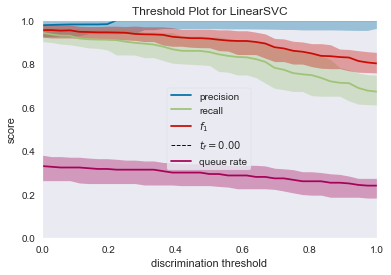

In [99]:
visualiser = DiscriminationThreshold(svc_model)
visualiser.fit(x, y)
visualiser.show()

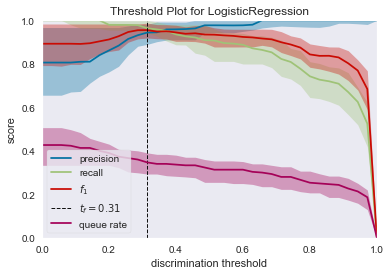

In [100]:
visualiser = DiscriminationThreshold(logreg)
visualiser.fit(x, y)
visualiser.show()

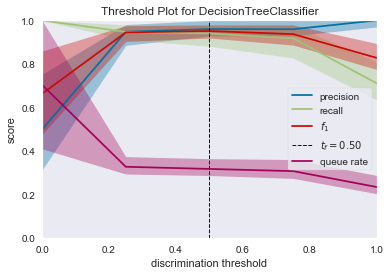

In [101]:
visualiser = DiscriminationThreshold(clf)
visualiser.fit(x, y)
visualiser.show()

In [102]:
# generate a no skill prediction (majority class)
ns_prob = [0 for _ in range(len(y_test))]

# predict probabilities
nb_learn_prob = gnb.predict_proba(x_test)

# keep only positive predictions
nb_learn_prob = nb_learn_prob[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_prob)
lr_auc = roc_auc_score(y_test, nb_learn_prob)

# summarize scores
print("No Skill ROC AUC= %.3f" % ns_auc)
print("Naive Bayes ROC AUC= %.3f" % lr_auc)

# calculate roc curves
ns_fpr, ns_tpr, thresholds = roc_curve(y_test, ns_prob)
nb_fpr, nb_tpr, thresholds = roc_curve(y_test, nb_learn_prob)

# plot the model
plt.plot(ns_fpr, ns_tpr, linestyle = '--', label= "No Skill")
plt.plot(nb_fpr, nb_tpr, marker= '.', label= "Naive Bayes")
plt.title("ROC Curve for NaiveBayes Risk Classifier")
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.legend()

NotFittedError: This GaussianNB instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.